In [3]:
import sys 

sys.path.append('../scripts')

In [5]:
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DistilBertForSequenceClassification, DistilBertTokenizer
import torch
from evaluate import evaluate
from prepare_data import create_prompts
from warp_training import train_warp

In [7]:
import yaml

with open('../configs/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [8]:
torch.cuda.is_available()

True

Experiments with different T as an example

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
sft_model = GPT2LMHeadModel.from_pretrained('lvwerra/gpt2-imdb').to(device)
reward_model = DistilBertForSequenceClassification.from_pretrained('../results/reward/checkpoint-4221').to(device)
reward_tokenizer = DistilBertTokenizer.from_pretrained('../results/reward/checkpoint-4221')
sft_model_tokenizer = GPT2Tokenizer.from_pretrained('lvwerra/gpt2-imdb')
sft_model_tokenizer.pad_token = sft_model_tokenizer.eos_token

In [ ]:
reward_warp = {}
kl_div_dict = {}
sft_rewards_all = []
for T in [100, 150, 200]:
    config['training_params']['training_steps'] = T
    warp_model = train_warp(config)
    
    # Оценка моделей
    warp_rewards, sft_rewards, kl_div = evaluate(
        sft_model,
        warp_model,
        sft_model_tokenizer,
        reward_model,
        reward_tokenizer,
        device,
        config
    )
    # Сохранение результатов
    reward_warp[T] = warp_rewards
    kl_div_dict[T] = kl_div
    sft_rewards_all.append(sft_rewards)
# Вывод результатов
print('Reward Warp:', reward_warp)
print('KL Divergence Dict:', kl_div_dict)

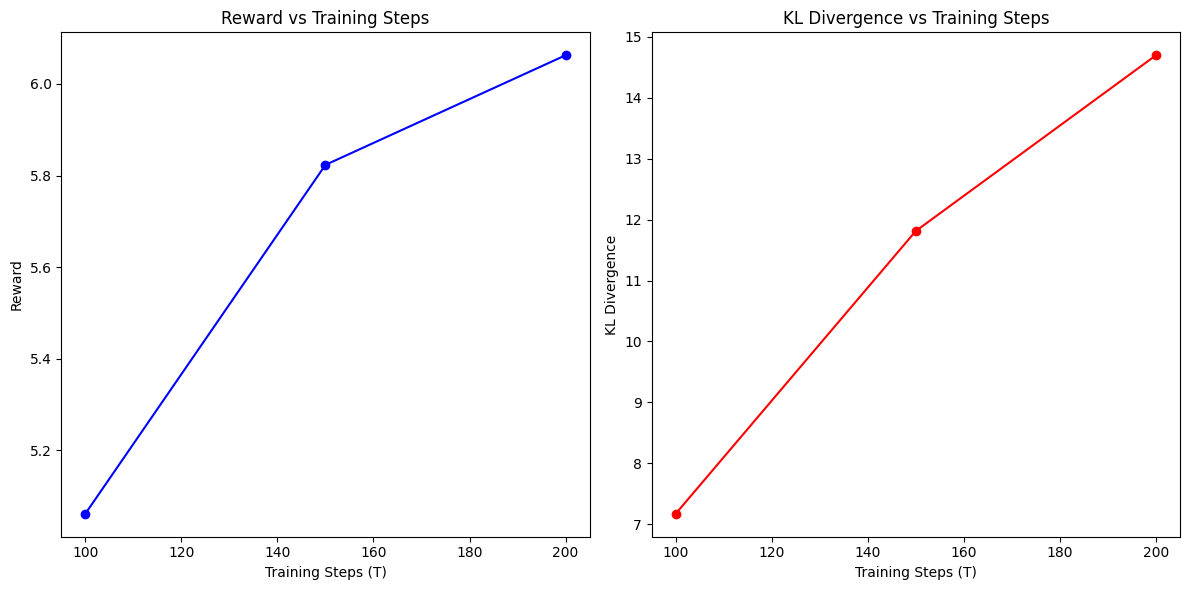

In [10]:
T_values = list(reward_warp.keys())
reward_values = list(reward_warp.values())
kl_values = list(kl_div_dict.values())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(T_values, reward_values, marker='o', linestyle='-', color='b')
plt.xlabel('Training Steps (T)')
plt.ylabel('Reward')
plt.title('Reward vs Training Steps')

plt.subplot(1, 2, 2)
plt.plot(T_values, kl_values, marker='o', linestyle='-', color='r')
plt.xlabel('Training Steps (T)')
plt.ylabel('KL Divergence')
plt.title('KL Divergence vs Training Steps')

plt.tight_layout()
plt.show()

From the graph, it is evident that as the number of iterations increases, both *reward* and *KL* increase. This is because we directly optimize our model for *reward*, and *KL* grows as we move away from the initial distribution, even though we try to keep it in place.

I would like to summarize the experimental results from the implementation of the algorithm. As $\mu$ increases in EMA, our model will move further away from the initial model toward the policy, which will increase both *KL* and *reward*. We choose a sufficiently small $\mu$ to avoid losing the initial distribution and to retain the model's generalization ability.

The parameter $\lambda$ determines how inclined the model is toward one of the two (or more) models we are interpolating between. Therefore, it is not possible to definitively say whether there is a trend toward increasing or decreasing metrics.

Similarly, as $\nu$ increases, we move further away from the initial model parameters during interpolation, which increases *KL*. This can be seen as a step in gradient descent (we move from the initial model toward the desired one with a learning rate of $\nu$).

Unfinished tasks: Try a *scheduler* for $\nu$, evaluate the dependence of model quality on batch sizes and the amount of input data.

### In the next part we can see results of aligning model to make positive comments on films

In [7]:
from prepare_data import create_prompts

In [18]:
warp_model = GPT2LMHeadModel.from_pretrained(config['model_paths']['output_model']).to(device)
base_model = GPT2LMHeadModel.from_pretrained('lvwerra/gpt2-imdb').to(device)

In [20]:
prompts = create_prompts()
sft_model_tokenizer.pad_token = sft_model_tokenizer.eos_token
for prompt in prompts[:5]:
    inputs = sft_model_tokenizer(
        prompt, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        return_attention_mask=True
    ).to(device)
    
    if 'input_ids' not in inputs or 'attention_mask' not in inputs:
        raise ValueError("Tokenization did not return 'input_ids' or 'attention_mask'.")
    
    outputs = base_model.generate(
        input_ids=inputs['input_ids'],  
        attention_mask=inputs['attention_mask'],  
        pad_token_id=sft_model_tokenizer.eos_token_id,
        max_length=65  
    )
    
    # Декодируем выходные данные
    decoded_output = sft_model_tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(decoded_output)

100%|██████████| 25000/25000 [00:00<00:00, 56548.32it/s]


I rented I AM CURIOUS-YELP, and I was so excited to see it. I was so excited to see it. I was so excited to see it. I was so excited to see it. I was so excited to see it. I was so excited to see it. I was so excited
"I Am Curious: Yellow" is a great movie. It is a great movie. It is a great movie. It is a great movie. It is a great movie. It is a great movie. It is a great movie. It is a great movie. It is a great movie. It is a great movie
If only to avoid making turds of the movie.
This film was probably in the top 10 of the best films of the year. It was a great film, and I think it deserves to be seen more than once.
Oh, brother...after hearii, you're gonna be a good girl...<br /><br />I'm not sure if this is a good movie, but it's a good movie. It's a good movie. It's a good movie. It's a good movie. It's a good movie.
